PU comparison

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from array import array

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
from prettytable import PrettyTable

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [21]:
def extractEff(fn):
    with open(fn) as f:
        for l in f.readlines():
            if not l.startswith('Eff'): continue
            return [float(l.split(' ')[1]), float(l.split(' ')[3])]
    return [None, None]

# B2DstMu

In [22]:
d = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU{}_10-2-3/'
d += 'ntuples_B2DstMu/skimmed/'

t = PrettyTable()
t.field_names = ['PU', 'Low', 'Mid', 'High']
dMC = {}
for PU in ['0', '20']:
    leff = []
    for cat in ['Low', 'Mid', 'High']:
        fn = d.format(PU) + cat
        leff.append(extractEff(fn + '.log'))

        dMC[cat+PU] = rtnp.root2array(fn+'.root')
    t.add_row([PU] + ['{:.2f}+/-{:.2f}%'.format(float(e), float(de)) for e, de in leff])
print 'Selection efficiency'
print t

Selection efficiency
+----+---------------+---------------+---------------+
| PU |      Low      |      Mid      |      High     |
+----+---------------+---------------+---------------+
| 0  | 25.20+/-0.08% | 18.80+/-0.08% | 19.40+/-0.08% |
| 20 | 15.40+/-0.04% | 13.20+/-0.04% | 16.70+/-0.04% |
+----+---------------+---------------+---------------+


0
70.99490643730225
25.193
20
66.78345078154906
15.387


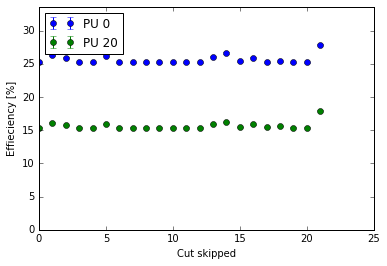

In [41]:
gEff = {0:[], 20:[]}
for PU in [0, 20]:
    for c in [None] + list(range(1,22)):
        fn = d.format(PU) + 'Low'
        if not c is None:
            fn += '_skip'+str(c)
        gEff[PU].append(extractEff(fn + '.log'))

for PU in gEff.keys():
    arr = np.array(gEff[PU])
    print PU
    print 100*np.product(arr[0,0]/arr[1:,0])
    print arr[0,0]
    idx = np.argmin(arr[:,0])
    plt.errorbar(np.arange(arr.shape[0]), arr[:,0], yerr=arr[:,1], label='PU '+str(PU), fmt='o')
plt.ylabel('Effieciency [%]')
plt.xlabel('Cut skipped')
plt.ylim(0, 1.2*plt.ylim()[1])
plt.legend(loc='best')

In [7]:
tMC20_ntuples = rt.TChain('outA/Tevts')
for f in glob(d.format(20).replace('skimmed/', 'out_*.root')):
    tMC20_ntuples.Add(f)

In [8]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Events
from DataFormats.FWLite import Handle

handle = {}
handle['vtx'] = [Handle('vector<reco::Vertex>'), 'offlineSlimmedPrimaryVertices']
NN = 50000
N_vtx_MINIAOD = []
pathMC_MINIAOD = '/mnt/hadoop/store/user/ocerri/cmsMC_private_PU20_10-2-3/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_200113/200113_224052/*/out_MINIAODSIM_*.root'
pb = ProgressBar(NN)
for fn in glob(pathMC_MINIAOD):
    for event in Events(fn):
        prods = {}
        for k,v in handle.iteritems():
            event.getByLabel(v[1], v[0])
            prods[k] = v[0].product()
        N_vtx_MINIAOD.append(prods['vtx'].size())
        pb.show(len(N_vtx_MINIAOD)-1)
        if len(N_vtx_MINIAOD) >= NN: break
    if len(N_vtx_MINIAOD) >= NN: break
N_vtx_MINIAOD = np.array(N_vtx_MINIAOD)

[####################]  100% - Tot. time: 128.9 s
[####################]  100% - ETA:    0 s   

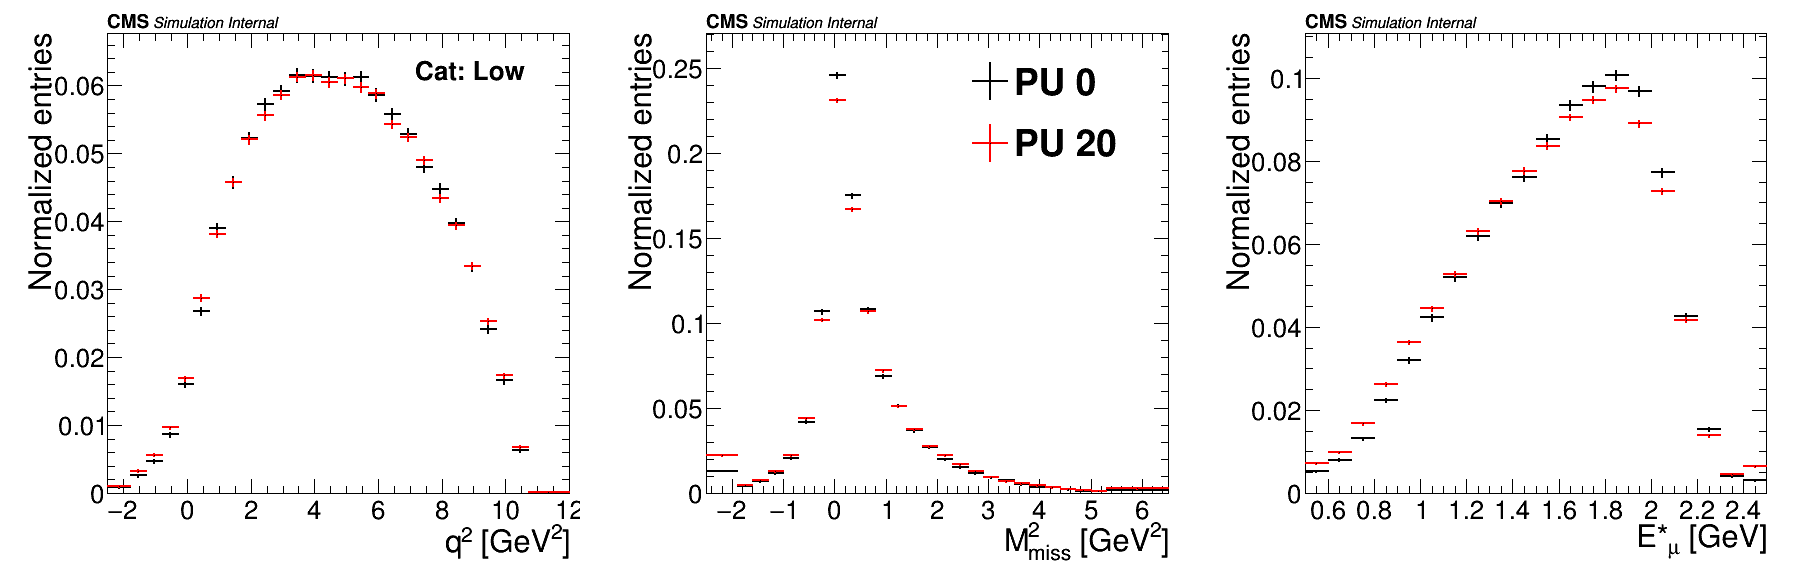

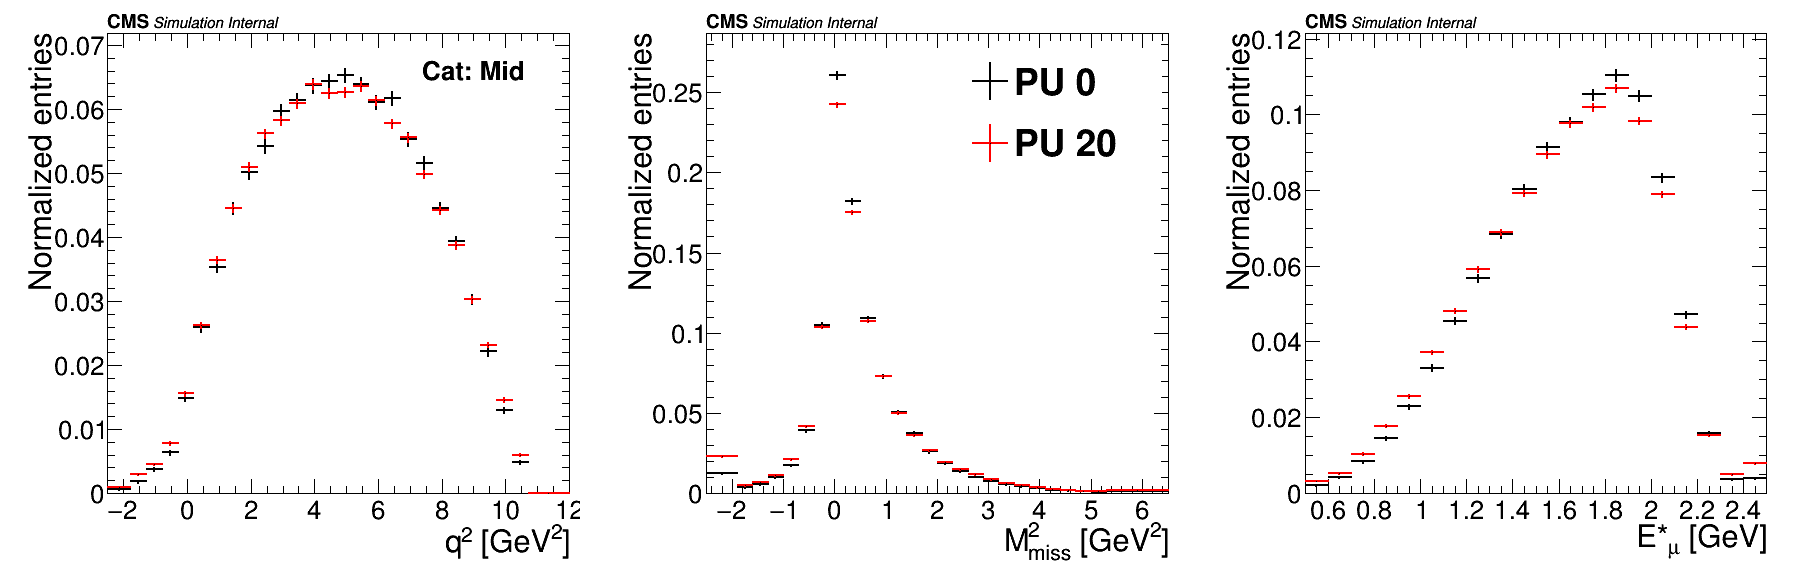

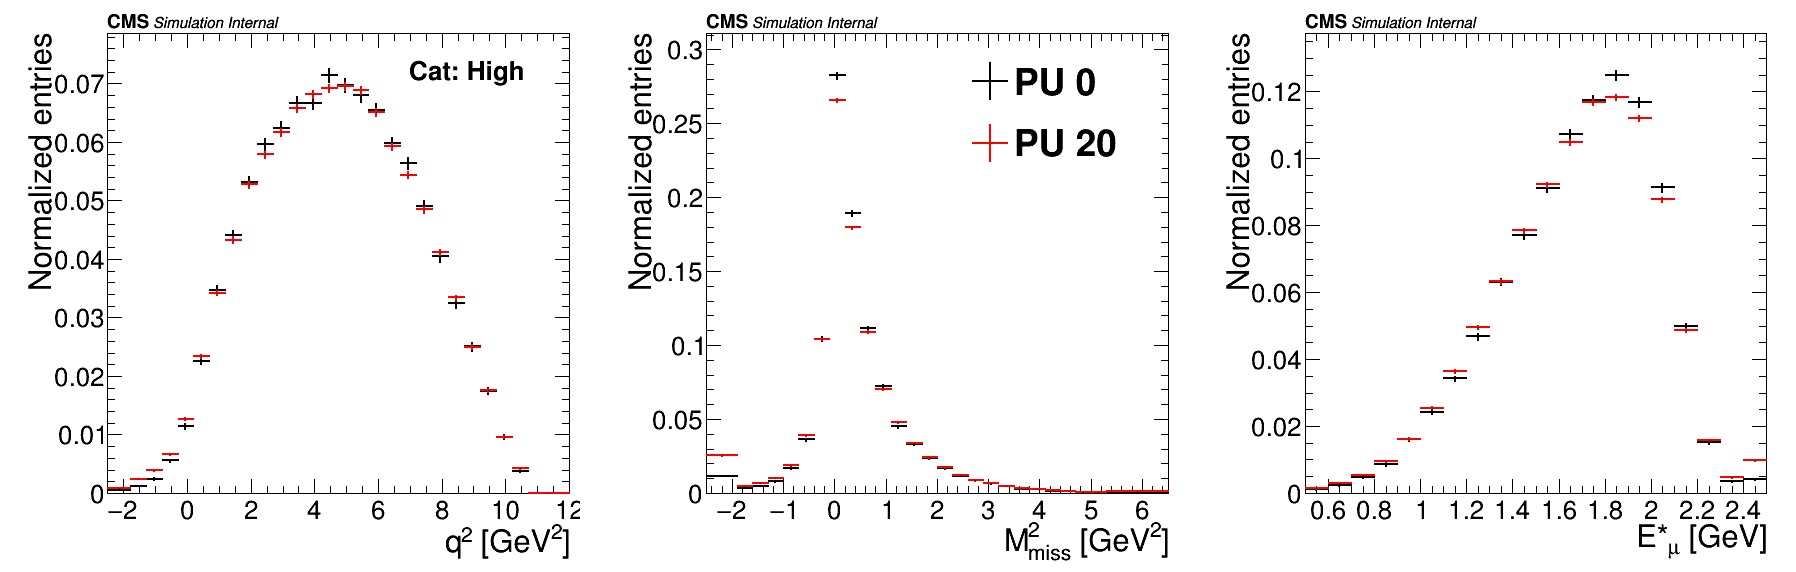

In [9]:
donotdelete = []
CMS_lumi.extraText = 6*' '+'Simulation Internal'
for cat in ['Low', 'Mid', 'High']:
    h0q2 =  create_TH1D(dMC[cat+'0']['q2'], name='h0q2'+cat+PU, title='', 
                        axis_title=['q^{2} [GeV^{2}]', 'Normalized entries'],
                        binning=array('d', [-2.5] + list(np.arange(-1.8, 11, 0.5)) + [12] ),
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                        opt='overflow+underflow'
                       )
    h20q2 =  create_TH1D(dMC[cat+'20']['q2'], name='h20q2'+cat+PU, title='', 
                        binning=h0q2.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                         opt='overflow+underflow'
                       )
    h20q2.SetLineColor(2)
    
    h0M =  create_TH1D(dMC[cat+'0']['M2_miss'], name='h0M'+cat+PU, title='', 
                        axis_title=['M^{2}_{miss} [GeV^{2}]', 'Normalized entries'],
                        binning=array('d', [-2.5] + list(np.arange(-1.9, 5.5, 0.3)) + [6.5] ),
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                       opt='overflow+underflow'
                       )
    h20M =  create_TH1D(dMC[cat+'20']['M2_miss'], name='h20M'+cat+PU, title='', 
                        binning=h0M.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                        opt='overflow+underflow'
                       )
    h20M.SetLineColor(2)
    
    h0E =  create_TH1D(dMC[cat+'0']['Est_mu'], name='h0E'+cat+PU, title='', 
                        axis_title=['E*_{#mu} [GeV]', 'Normalized entries'],
                        binning=[20, 0.50, 2.500],
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                       opt='overflow+underflow'
                       )
    h20E =  create_TH1D(dMC[cat+'20']['Est_mu'], name='h20E'+cat+PU, title='', 
                        binning=h0E.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                        opt='overflow+underflow'
                       )
    h20E.SetLineColor(2)
    
    c = rt.TCanvas('c'+cat, 'c'+cat, 50, 50, 1800, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    c.Divide(3)
    
    pad = c.cd(1)
    SetMaxToMaxHist([h0q2, h20q2])
    h0q2.Draw()
    h20q2.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    text = rt.TText(0.9, 0.9, 'Cat: '+cat)
    text.SetTextAlign(33)
    text.SetNDC()
    text.Draw()
    
    pad = c.cd(2)
    SetMaxToMaxHist([h0M, h20M])
    h0M.Draw()
    h20M.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    leg = rt.TLegend(0.62, 0.7, 0.97, 0.92)
    leg.AddEntry(h0M, 'PU 0', 'lep')
    leg.AddEntry(h20M, 'PU 20', 'lep')
    leg.SetBorderSize(0)
    leg.Draw()
    
    pad = c.cd(3)
    SetMaxToMaxHist([h0E, h20E])
    h0E.Draw()
    h20E.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    
    donotdelete.append([c, leg, text, h0q2, h20q2, h0M, h20M, h0E, h20E])
    
    c.Draw()

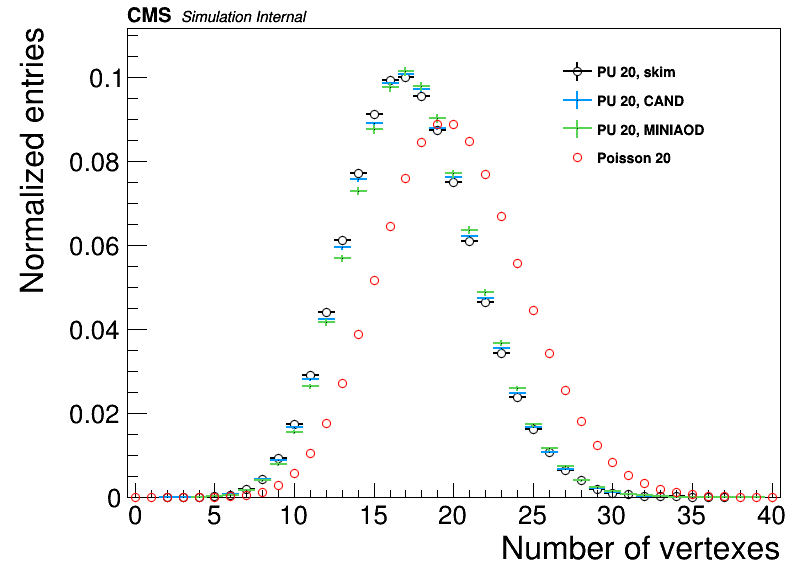

In [10]:
from scipy.stats import poisson
leg = rt.TLegend(0.7, 0.7, 0.9, 0.9)
leg.SetBorderSize(0)

h20N =  create_TH1D(dMC[cat+'20']['N_vtx'], name='h20N', title='', 
                    axis_title=['Number of vertexes', 'Normalized entries'],
                    binning=[41, -0.5, 40.5],
                    scale_histo=1./len(dMC[cat+'20']['q2'])
                   )
h20N.SetMarkerStyle(4)
h20N.SetMarkerColor(1)
leg.AddEntry(h20N, 'PU 20, skim', 'lep')

h20Nn = h20N.Clone('h20Nn')
tMC20_ntuples.Project('h20Nn', 'N_vertexes', '')
h20Nn.Scale(1./h20Nn.Integral())
h20Nn.SetLineColor(rt.kAzure+7)
h20Nn.SetMarkerStyle(1)
leg.AddEntry(h20Nn, 'PU 20, CAND', 'lep')

h20NM =  create_TH1D(N_vtx_MINIAOD, name='h20NM', title='', 
                    binning=h20N.binning,
                    scale_histo=1./len(N_vtx_MINIAOD)
                   )
h20NM.SetLineColor(8)
leg.AddEntry(h20NM, 'PU 20, MINIAOD', 'lep')

h20N_id = h20N.Clone()
for i in range(1, h20N_id.GetNbinsX()+1):
    h20N_id.SetBinContent(i, poisson.pmf(i-1, 20))
h20N_id.SetLineWidth(0)
h20N_id.SetMarkerStyle(4)
h20N_id.SetMarkerColor(2)
leg.AddEntry(h20N_id, 'Poisson 20', 'lep')

hl = [h20N, h20Nn, h20NM, h20N_id]
SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

# B2JspiKst

# Load data

In [ ]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3'
datasets_loc = glob(dataDir + '/ntuples_B2JpsiKst/out_CAND_*.root')

Tmc20 = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    Tmc20.Add(floc)

print 'N evts: {:.0f}'.format(Tmc20.GetEntries())

In [ ]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3'
datasets_loc = glob(dataDir + '/ntuples_B2JpsiKst/out_CAND_*.root')

Tmc0 = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    Tmc0.Add(floc)

print 'N evts: {:.0f}'.format(Tmc0.GetEntries())

In [ ]:
datasets_loc = glob('../data/cmsRD/ParkingBPH1/*2018C-*B2JpsiKst_200124_CAND.root')
TrdC = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    TrdC.Add(floc)

print 'N evts: {:.0f}'.format(TrdC.GetEntries())

# Plots

In [ ]:
def plot(var, binning, cut_str='', axis_title=['', ''], leg_loc=[0.7, 0.7, 0.8, 0.9]):
    h1 = create_TH1D(np.zeros(0), name='h1', title='RD', axis_title=axis_title, binning=binning)
    TrdC.Project('h1', var, cut_str)

    h2 = create_TH1D(np.zeros(0), name='h2', title='MC 0', binning=binning)
    Tmc0.Project('h2', var, cut_str)
    
    h3 = create_TH1D(np.zeros(0), name='h3', title='MC 20', binning=binning)
    Tmc20.Project('h3', var, cut_str)
    
    leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[2], leg_loc[3])
    leg.SetBorderSize(0)
    h_list = [h1, h2, h3]
    colors = [rt.kBlack, rt.kRed, rt.kBlue]
    
    for i, h in enumerate(h_list):
        h.Sumw2()
        h.Scale(1./h.Integral())
        h.SetLineColor(colors[i])
        leg.AddEntry(h, h.GetTitle(), 'lep')

    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    c.SetRightMargin(0.15)
    c.dnd = [h_list, leg]
    leg.Draw()
    c.Draw()

    return c

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], '', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu12_IP6)>0', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu9_IP6)>0', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu7_IP4)>0', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('n_B', [20, 0.5, 20.5], 'Sum$(trgMu_HLT_Mu12_IP6)>0', axis_title=['n_{B}', 'Norm.'])
c.SetLogy()

In [ ]:
c = plot('n_B', [20, 0.5, 20.5], 'Sum$(trgMu_HLT_Mu7_IP4)>0', axis_title=['n_{B}', 'Norm.'])
c.SetLogy()

In [ ]:
analysis_sel = ['n_B == 1',
                'mass_mumu < 3.176',
                'mass_mumu > 3.012',
                'mass_piK > 0.82',
                'mass_piK < 0.96',
                'mum_pt > 3.5',
                'mup_pt > 3.5',
                'Jpsi_pt > 6.9',
                'pval_mumu > 0.1',
                'mum_eta > -2.2',
                'mup_eta > -2.2',
                'mum_eta < 2.2',
                'mup_eta < 2.2',
                'cosT_Jpsi_PV > 0.95',
                'mum_dxy < 3',
                'mup_dxy < 3',
                'pval_piK > 0.1',
                'K_pt > 0.8',
                'mass_KK > 1.035', 
                'K_sigdxy_PV > 2',
                'pi_sigdxy_PV > 2', 
                'sigdxy_vtxKst_PV > 5',
                'fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895)', 
                'pval_mumupiK > 0.1', 'pi_pt > 0.8']

In [ ]:
c = plot('mass_mumupiK', [40, 5.05, 5.5], ' && '.join(analysis_sel), axis_title=['mass #mu#mu#piK [GeV]', 'Norm.'])

In [ ]:
c = plot('mass_piK', [150, 0.6, 1.4], ' && '.join(analysis_sel), axis_title=['mass #piK [GeV]', 'Norm.'])